<h1><center>Data Analysis</center></h1>
<h2><center>Kaggle report notebook</center></h2>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Introduce yourself

Put your team name and team-members' names below

команда: ПолюхаИоганн, 
участники: Полина Томм, Иван Токарев, Михаил Затепякин

# Task

In this task we are working with posts on famous russian advertisement and resell platform.

Ginen information about the post and corresponding item you have to estimate its probability to be sold in 3 days.

Below you will find some desirable stages of your report.

# Data Loading

In [6]:
# initial_df, initial_test_df - исходные файлы датасета, train_df, test_df - модифицированные файлы 
# с уже лемматизиронными описаниями - для экономии времени выделили в отдельные файлы т. к. данная процедура времязатратная
initial_test_df = pd.read_csv('test.tsv', sep='\t', parse_dates = ['date_created'])
initial_df = pd.read_csv('train.tsv', sep='\t', parse_dates = ['date_created'])
train_df = pd.read_csv('df.csv')
test_df = pd.read_csv('test_df.csv')

In [7]:
train_df['text'].fillna('', inplace=True)
test_df['text'].fillna('', inplace=True)

# Чистим и преобразуем данные

In [8]:
def preprocess_df(df, colsToDrop):
  df = df.drop(labels=colsToDrop, axis='columns')
  df[['delivery_available', 'payment_available']] *= 1
  return df

initial_test_df = preprocess_df(initial_test_df, ['Unnamed: 0'])
initial_df = preprocess_df(initial_df, ['Unnamed: 0'])
train_df = preprocess_df(train_df, ['Unnamed: 0'])
test_df  = preprocess_df(test_df, ['Unnamed: 0'])

# Descriptive Data Analysis

* Analyze train dataset features
    * Provide some meaningfull description about corresponding features (in form of pictures or some coefficients)
    * Outline any findings you are able to reveal
* Try to measure analyse any correspondense between features and target features

# Анализ признака-даты

Нарисуем график количества проданных и не проданных товаров по каждой дате в датасете:

In [9]:
dict_trend_pos = {}
dict_trend_neg = {}
for i in initial_df['date_created']:
  dict_trend_pos[i] = 0
  dict_trend_neg[i] = 0
  
  
for (i, a) in zip(initial_df['date_created'], initial_df['sold_fast']):
  dict_trend_pos[i] += a
  dict_trend_neg[i] += (a == 0)
  
pos = [dict_trend_pos[key] for key in sorted(dict_trend_pos.keys())]
neg = [dict_trend_neg[key] for key in sorted(dict_trend_neg.keys())]
ticks = sorted(dict_trend_pos.keys())

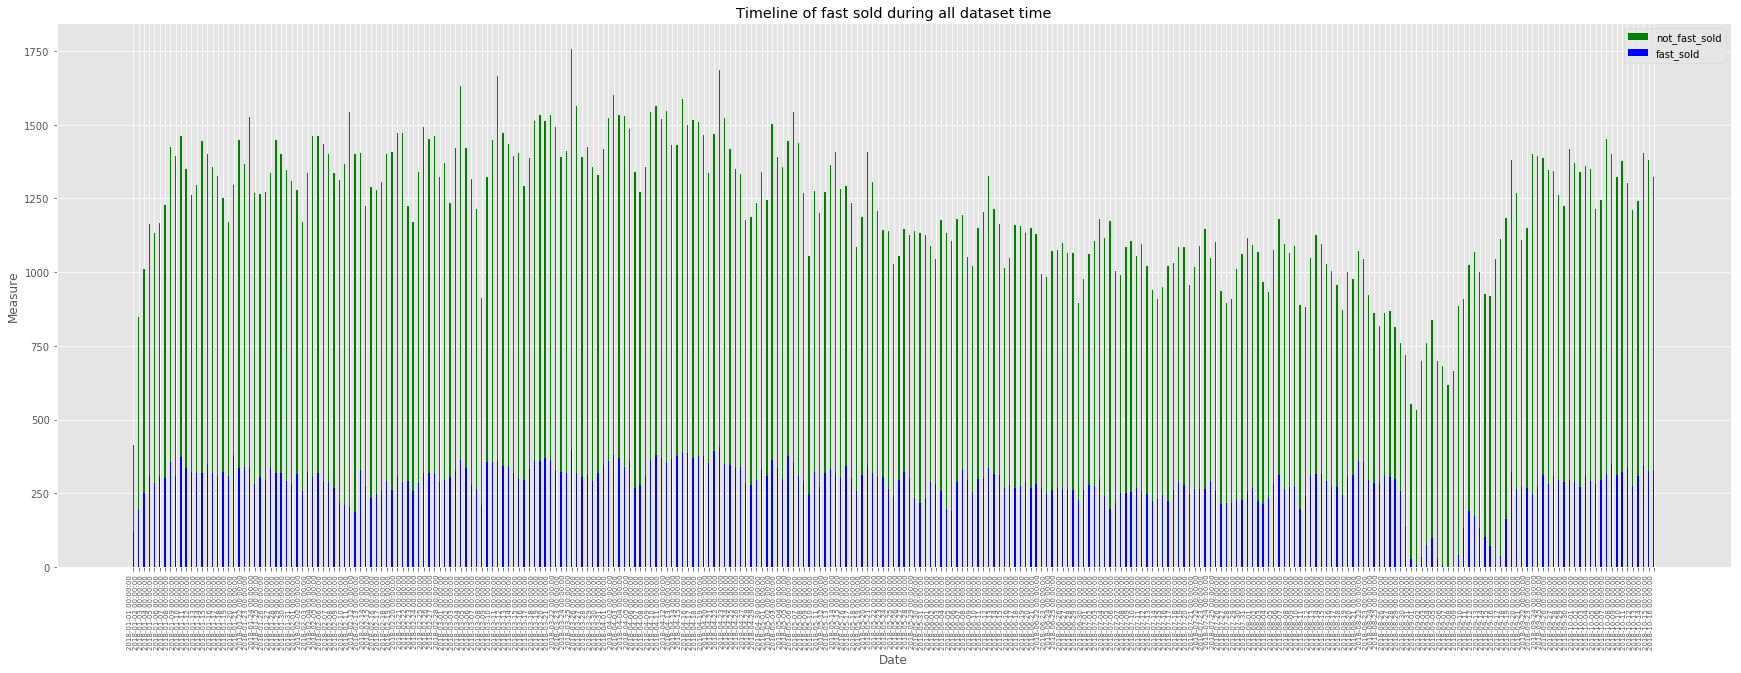

In [10]:
ticks = np.array(list(ticks))
pos = np.array(list(pos))
neg = np.array(list(neg))


plt.figure(figsize=(30, 10))
plt.bar(ticks, neg, width=0.25, label='not_fast_sold', color='green', bottom=pos)
plt.bar(ticks, pos, width=0.25, label='fast_sold', color='blue')

plt.xticks(ticks, ticks, )
plt.ylabel("Measure")
plt.xlabel("Date")
plt.legend(loc="upper right")
plt.title("Timeline of fast sold during all dataset time")
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right', fontsize=7)

plt.show()

График содержит немного интересной информации, но если повнимательнее изучить - некоторые закономерности есть - локальные эктремумы достигаются чаще всего на выходных (сб, вс) или в начале недели (пн) (для этого вручуную переводили дату в день недели),  также есть тренд на уменьшение объема продаж в сентябре. 

На основании этого было принято решение признак-дату из датасета исключить и добавить более полезные признаки - месяц, время года, день недели, день месяца и выходной ли это день:

In [11]:
def process_date(dfToChange):
  dfToChange['month'] = dfToChange['date_created'].dt.month
  dfToChange['quarter'] = dfToChange['date_created'].dt.quarter
  dfToChange['dayofweek'] = dfToChange['date_created'].dt.dayofweek
  dfToChange['dayofmonth'] = dfToChange['date_created'].dt.day
  dfToChange['is_weekend'] = np.where((dfToChange['date_created'].dt.weekday_name).isin(['Sunday','Saturday']),1,0)
  return dfToChange

In [12]:
initial_df = process_date(initial_df)
initial_test_df = process_date(initial_test_df)

In [13]:
initial_df = initial_df.drop(labels=['date_created'], axis='columns')
initial_test_df = initial_test_df.drop(labels=['date_created'], axis='columns')

# Анализ desc_text признака

In [14]:
overall_products_num = len(train_df['sold_fast'])
neg_num = len(train_df['sold_fast']) - sum(train_df['sold_fast'])
pos_num = sum(train_df['sold_fast'])

print('всего товаров:', overall_products_num)
print('не купили в течение 3-х дней:', neg_num)
print('купили в течение 3-х дней:', pos_num)

всего товаров: 351281
не купили в течение 3-х дней: 270201
купили в течение 3-х дней: 81080


In [15]:
pos_words = 0
neg_words = 0
for (text, is_sold) in zip(train_df['desc_text'], train_df['sold_fast']):
  if (is_sold == 1):
    pos_words += len(text.split())
  else:
    neg_words += len(text.split())

In [16]:
print('средняя длина описания купленного товара (в словах):', pos_words / pos_num)

средняя длина описания купленного товара (в словах): 18.763801184015787


In [17]:
print('средняя длина описания не купленного товара (в словах):', neg_words / neg_num)

средняя длина описания не купленного товара (в словах): 20.061102660611915


Делаем вывод, что длина описания почти ничего не значит. Нормализуем текст:

In [18]:
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [19]:
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import re
from string import punctuation

# лемматизируем
def my_preproc_lemma(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    return " ".join(pymorphy2_analyzer.parse(str(word))[0].normal_form for word in text.split())

# удаляем стоп слова
def my_preproc(text):
    text = my_preproc_lemma(text)
    return " ".join([word for word in text.split() if word not in stopwords.words('russian') + [' ', '\n']])

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivantokarev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# долгая процедура, заранее сделали и выделили в отдельный файл
# %%time
# train_df["text"] = train_df["desc_text"].apply(lambda x: my_preproc(x))


In [21]:
initial_df["text"] = train_df["text"]
initial_test_df["text"] = test_df["text"]

In [22]:
initial_df.head()

,category_id,city,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,...,region,sold_mode,subcategory_id,sold_fast,month,quarter,dayofweek,dayofmonth,is_weekend,text
0,4,Краснодар,0,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,1,...,Краснодарский край,1,410,1,10,4,0,8,0,продавать стол раскладной деревянный советский...
1,4,Тюмень,0,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,0,...,Тюменская область,1,405,0,6,2,0,18,0,тарелка глубокий 6 шт блюдце чашка 6 шт весь р...
2,9,Омск,1,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,1,...,Омская область,1,908,0,7,3,1,31,0,новыйс этикетка размер l подойти размерумаломе...
3,3,Санкт-Петербург,0,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,1,...,Ленинградская область,1,312,0,4,2,1,17,0,складываться трость весь колесо вниз сплошной ...
4,5,Москва,0,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,1,...,Московская область,1,504,0,2,1,4,9,0,неразлучник птичка 15 год продавать большой кл...


Создадим тестовые признаки и оценим их эффективность - количество слов, символов, средняя длина слова, количество стоп-слов:

In [23]:
stoppings = stopwords.words('russian')
initial_df['word_count']= initial_df["text"].apply(lambda x: len(str(x).split()))
initial_test_df['word_count']= initial_test_df["text"].apply(lambda x: len(str(x).split()))

initial_df['characters_count'] = initial_df["text"].apply(lambda x: len(str(x)))
initial_df['average_word_length'] = initial_df['characters_count'] / initial_df['word_count']
initial_df['average_word_length'][np.isnan(initial_df['average_word_length'])] = 0
initial_df['stopwords_count'] = initial_df["desc_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stoppings]) )



/Users/ivantokarev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [24]:
initial_df.head()

,category_id,city,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,...,month,quarter,dayofweek,dayofmonth,is_weekend,text,word_count,characters_count,average_word_length,stopwords_count
0,4,Краснодар,0,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,1,...,10,4,0,8,0,продавать стол раскладной деревянный советский...,13,102,7.846154,1
1,4,Тюмень,0,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,0,...,6,2,0,18,0,тарелка глубокий 6 шт блюдце чашка 6 шт весь р...,22,146,6.636364,6
2,9,Омск,1,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,1,...,7,3,1,31,0,новыйс этикетка размер l подойти размерумаломе...,15,101,6.733333,7
3,3,Санкт-Петербург,0,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,1,...,4,2,1,17,0,складываться трость весь колесо вниз сплошной ...,53,383,7.226415,22
4,5,Москва,0,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,1,...,2,1,4,9,0,неразлучник птичка 15 год продавать большой кл...,9,66,7.333333,3


In [25]:
def analyze(param):
  pos_words = 0.0
  neg_words = 0.0
  for (count, is_sold) in zip(initial_df[param], initial_df['sold_fast']):
    if (is_sold == 1):
      pos_words += count
    else:
      neg_words += count
    
  return (pos_words, neg_words)

pos_words, neg_words = analyze('word_count')
print('после обработки и лемматизации:')
print('средняя длина описания купленного товара (в словах):', pos_words / pos_num)
print('средняя длина описания не купленного товара (в словах):', neg_words / neg_num)
print('отношение: ', (pos_words / pos_num) / (neg_words / neg_num))

после обработки и лемматизации:
средняя длина описания купленного товара (в словах): 14.451788357178096
средняя длина описания не купленного товара (в словах): 15.469291379380536
отношение:  0.9342243288817548


In [26]:
pos_words, neg_words = analyze('characters_count')
print('после обработки и лемматизации:')
print('средняя длина описания купленного товара (в символах):', pos_words / pos_num)
print('средняя длина описания не купленного товара (в символах):', neg_words / neg_num)
print('отношение: ', (pos_words / pos_num) / (neg_words / neg_num))

после обработки и лемматизации:
средняя длина описания купленного товара (в символах): 109.84892698569314
средняя длина описания не купленного товара (в символах): 117.82485631067243
отношение:  0.9323069038679842


In [27]:
# Очень слабо различимо - плохой новый признак
pos_words, neg_words = analyze('average_word_length')
print('после обработки и лемматизации:')
print('средняя длина слова в описании купленного товара (в символах):', pos_words / pos_num)
print('средняя длина слова в описания не купленного товара (в символах):', neg_words / neg_num)
print('отношение: ', (pos_words / pos_num) / (neg_words / neg_num))

после обработки и лемматизации:
средняя длина слова в описании купленного товара (в символах): 7.551591317056316
средняя длина слова в описания не купленного товара (в символах): 7.544155603796903
отношение:  1.0009856256485046


In [28]:
# Очень слабо различимо - плохой новый признак
pos_words, neg_words = analyze('stopwords_count')
print('на оригинальном тексте описания:')
print('среднее количество стоп слов в описании купленного товара (в символах):', pos_words / pos_num)
print('среднее количество стоп слов в описании не купленного товара (в символах):', neg_words / neg_num)
print('отношение: ', (pos_words / pos_num) / (neg_words / neg_num))

на оригинальном тексте описания:
среднее количество стоп слов в описании купленного товара (в символах): 3.831228416378885
среднее количество стоп слов в описании не купленного товара (в символах): 4.046483913827114
отношение:  0.946804311586984


Найдем самые популярные слова в описании товаров:

In [29]:
all_text_without_sw = ''
for i in initial_df.itertuples():
    all_text_without_sw = all_text_without_sw +  str(i.text)
    
# removing digits
all_text_without_sw = ''.join([i for i in all_text_without_sw if not i.isdigit()])

from collections import Counter
import operator
counts = Counter(re.findall(r"[\w']+", all_text_without_sw))
#deleting ' from counts
del counts["'"]
sorted_x = dict(sorted(counts.items(), key=operator.itemgetter(1),reverse=True)[:15])

import collections
sorted_dict = collections.OrderedDict(sorted_x)

sorted_dict

OrderedDict([('состояние', 89908),
             ('весь', 54720),
             ('хороший', 45450),
             ('размер', 41240),
             ('отличный', 36861),
             ('комплект', 30568),
             ('новый', 28975),
             ('очень', 25857),
             ('работать', 23738),
             ('год', 23638),
             ('сантиметр', 22371),
             ('цена', 19769),
             ('телефон', 16936),
             ('торг', 16156),
             ('новое', 15968)])

In [30]:
initial_df['count_top_words'] = initial_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in sorted_x]) )
# Очень слабо различимо - плохой новый признак
pos_words, neg_words = analyze('count_top_words')
print('после обработки и лемматизации:')
print('среднее количество 25 самых популярных слов в описании купленного товара (в словах):', pos_words / pos_num)
print('среднее количество 25 самых популярных слов в описании не купленного товара (в словах):', neg_words / neg_num)
print('отношение: ', (pos_words / pos_num) / (neg_words / neg_num))

после обработки и лемматизации:
среднее количество 25 самых популярных слов в описании купленного товара (в словах): 1.717488899851998
среднее количество 25 самых популярных слов в описании не купленного товара (в словах): 1.7541792961536042
отношение:  0.9790840101795424


In [31]:
initial_df['count_punctuation'] = initial_df['desc_text'].apply(lambda x: len([w for w in str(x) if w in punctuation]) )
initial_test_df['count_punctuation'] = initial_test_df['desc_text'].apply(lambda x: len([w for w in str(x) if w in punctuation]) )


In [32]:
pos_words, neg_words = analyze('count_punctuation')
print('после обработки и лемматизации:')
print('среднее количество знаков пунктуации в описании купленного товара (в словах):', pos_words / pos_num)
print('среднее количество знаков пунктуации в описании не купленного товара (в словах):', neg_words / neg_num)
print('отношение: ', (pos_words / pos_num) / (neg_words / neg_num))

после обработки и лемматизации:
среднее количество знаков пунктуации в описании купленного товара (в словах): 5.9322890971879625
среднее количество знаков пунктуации в описании не купленного товара (в словах): 6.433951021646848
отношение:  0.9220289488106052


In [33]:
initial_df['count_upper_case'] = initial_df['desc_text'].apply(lambda x: len([w for w in str(x).replace('I','i').replace('A','a').split() if w.isupper() == True]) )
initial_test_df['count_upper_case'] = initial_test_df['desc_text'].apply(lambda x: len([w for w in str(x).replace('I','i').replace('A','a').split() if w.isupper() == True]) )

In [34]:
pos_words, neg_words = analyze('count_upper_case')
print('после обработки и лемматизации:')
print('среднее количество знаков пунктуации в описании купленного товара (в словах):', pos_words / pos_num)
print('среднее количество знаков пунктуации в описании не купленного товара (в словах):', neg_words / neg_num)
print('отношение: ', (pos_words / pos_num) / (neg_words / neg_num))

после обработки и лемматизации:
среднее количество знаков пунктуации в описании купленного товара (в словах): 0.6130611741489886
среднее количество знаков пунктуации в описании не купленного товара (в словах): 0.6640686007823805
отношение:  0.9231895220263436


На основе анализа уберем самые неэффективные сгенерированные признаки (там, где отношение не сильно меньше 1-цы):

In [35]:
initial_df = initial_df.drop(labels=['characters_count', 'average_word_length', 'stopwords_count', 'count_top_words'], axis='columns')

# Обрабатываем геоданные

Соединяем два датасета (трейн и тест) и формируем кластеры из признаков lat long. Соединение нужно, чтобы в тестовый датасет корректно подставить нужный номер кластера как новый признак. (Чтобы наша модель учась на трейн сете потом также интерпретиловала номера кластеров на тесте)

In [36]:
from sklearn.cluster import KMeans
X = pd.concat([initial_df.loc[:,['lat','long']], initial_test_df.loc[:,['lat','long']]], ignore_index=True)

In [37]:
X.shape

(440532, 2)

In [38]:
# 16 кластеров
id_n=16
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X)
id_label=kmeans.labels_

Нарисуем график всех кластеров относительно lat long:

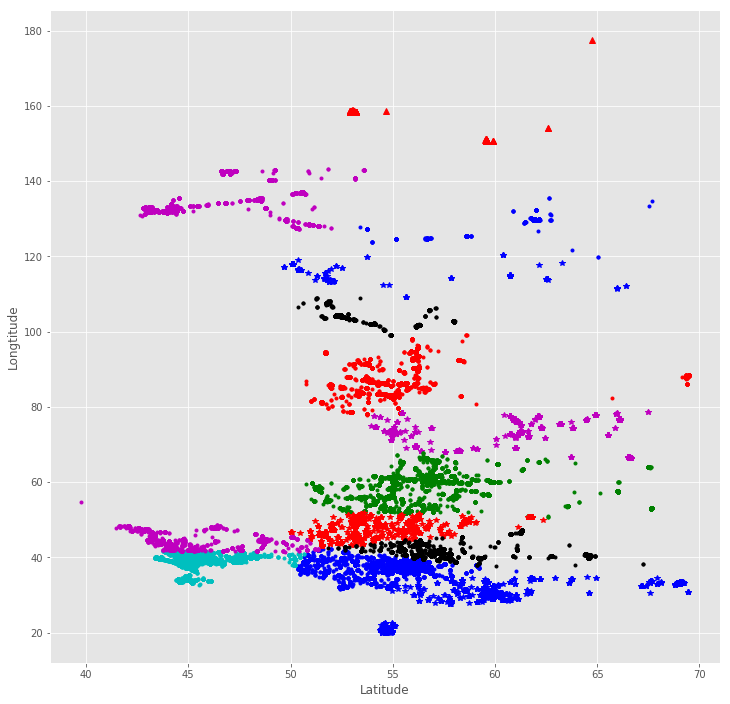

In [39]:
#plot result
ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^', 'b.','r.','m.','g.', 'k.','b*','r*']);
plt.figure(figsize=(12,12))
plt.ylabel('Longtitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    plt.plot(X.lat[cluster].values, X.long[cluster].values, ptsymb[i])
plt.show()

Сгенерируем новый признак - номер кластера:

In [40]:
initial_df['cluster'] = id_label[:len(initial_df['word_count'])]
initial_test_df['cluster'] = id_label[-len(initial_test_df['word_count']):]

Проверим, насколько информативен данный признак:

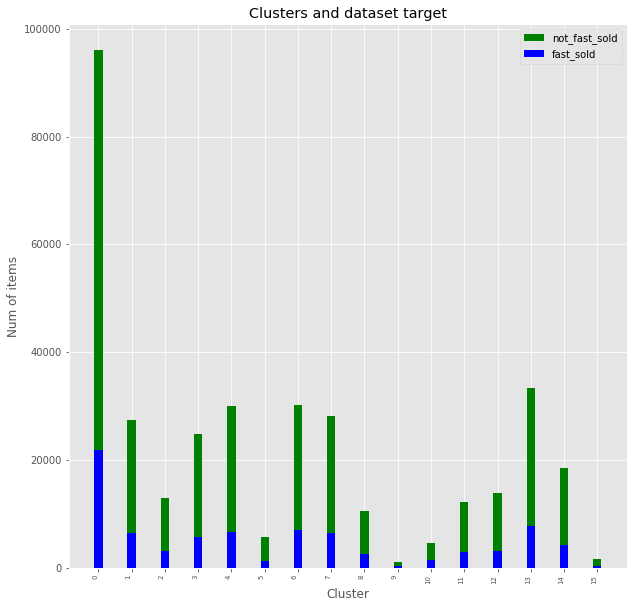

In [41]:
pos_dict = {}
neg_dict = {}

for i in range(0, 16):
  pos_dict[i] = 0
  neg_dict[i] = 0

for (cluster, is_sold) in zip(initial_df['cluster'], initial_df['sold_fast']):
  if (is_sold == 1):
    pos_dict[cluster] += 1
  else:
    neg_dict[cluster] += 1
    
ticks = np.arange(0, 16)
pos = list(pos_dict.values())
neg = list(neg_dict.values())

plt.figure(figsize=(10, 10))
plt.bar(ticks, neg, width=0.25, label='not_fast_sold', color='green', bottom=pos)
plt.bar(ticks, pos, width=0.25, label='fast_sold', color='blue')

plt.xticks(ticks, ticks, )
plt.ylabel("Num of items")
plt.xlabel("Cluster")
plt.legend(loc="upper right")
plt.title("Clusters and dataset target")
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right', fontsize=7)

plt.show()

In [42]:
# отношение не проданных к проданным товарам в каждом кластере
ratio = np.array(neg) / np.array(pos)
ratio

array([3.39933132, 3.27037959, 3.06857502, 3.32232841, 3.49221557,
       3.46105919, 3.28953356, 3.4339978 , 3.07142857, 2.69097222,
       2.3944485 , 3.23886779, 3.47490347, 3.33546118, 3.42630821,
       2.91489362])

Почти во всех кластерах довольно большое отхождение от 3-ки (именно в 3 раза больше объектов одного класса), что говорит о том что это хороший признак.

Также избавляемся от изначальных признаков lat long, их трудно интерпретировать, поскольку две рядом стоящие точки могут иметь отрицательные координаты. Заменяем их признаками-аналогами из трехмерного пространства:

In [43]:
# переводим признаки lat long в осмысленные признаки-координаты трехмерного пространства
import math
x_coord_train = []
y_coord_train = []
z_coord_train = []

for (lat, long) in zip(initial_df['lat'], initial_df['long']):
  x_coord_train.append(math.cos(lat) * math.cos(long))
  y_coord_train.append(math.cos(lat) * math.sin(long))
  z_coord_train.append(math.sin(lat))

x_coord_test = []
y_coord_test = []
z_coord_test = []

for (lat, long) in zip(initial_test_df['lat'], initial_test_df['long']):
  x_coord_test.append(math.cos(lat) * math.cos(long))
  y_coord_test.append(math.cos(lat) * math.sin(long))
  z_coord_test.append(math.sin(lat))
  
initial_df['x_coord'] = x_coord_train
initial_df['y_coord'] = y_coord_train
initial_df['z_coord'] = z_coord_train

initial_test_df['x_coord'] = x_coord_test
initial_test_df['y_coord'] = y_coord_test
initial_test_df['z_coord'] = z_coord_test

In [44]:
initial_df = initial_df.drop(labels=['lat', 'long'], axis='columns')
initial_test_df = initial_test_df.drop(labels=['lat', 'long'], axis='columns')

# Убираем шум из данных

owner_id, product_id - лишние признаки, desc_text, text - по ним сгенерировали новые и они не интерпретируемы в своем нынешнем виде, удаляем их

In [45]:
initial_df = initial_df.drop(labels=['text', 'desc_text', 'owner_id', 'product_id', 'properties', 'name_text'], axis='columns')
initial_test_df = initial_test_df.drop(labels=['text', 'desc_text', 'owner_id', 'product_id', 'properties', 'name_text'], axis='columns')


In [46]:
initial_test_df.columns

Index(['category_id', 'city', 'delivery_available', 'img_num',
       'payment_available', 'price', 'product_type', 'region', 'sold_mode',
       'subcategory_id', 'month', 'quarter', 'dayofweek', 'dayofmonth',
       'is_weekend', 'word_count', 'count_punctuation', 'count_upper_case',
       'cluster', 'x_coord', 'y_coord', 'z_coord'],
      dtype='object')

# (almost) Zero-knowledge prediction
* Develop non-machine learning approach to get predictions
    * Describe it and measure its quality on Kaggle

Примитивным классификатором может стать просто предсказание по правилу какой-то условной конструкции

In [47]:
def analyzePrice():
  pos_prices = []
  neg_prices = []
  for (price, is_sold) in zip(initial_df['price'], initial_df['sold_fast']):
    if (is_sold == 1):
      pos_prices.append(price)
    else:
      neg_prices.append(price)
    
  return (pos_prices, neg_prices)

pos_prices, neg_prices = analyzePrice()

In [48]:
print('медиана купленного товара (в символах):', np.median(pos_prices))
print('медиана не купленного товара (в символах):', np.median(neg_prices))

медиана купленного товара (в символах): 1500.0
медиана не купленного товара (в символах): 1300.0


In [49]:
threshold = (np.median(pos_prices) + np.median(neg_prices)) / 2

In [50]:
threshold

1400.0

Сделаем примитивнейший классификатор в зависимости от порога цены:

In [51]:
def classify(df):
    y_pred = df['price'].apply(lambda x: 0.8 if x > threshold else 0.3)
    return y_pred

# Sumissioning to kaggle

In [52]:
product_id = pd.read_csv('test.tsv', sep='\t', parse_dates = ['date_created'])['product_id']

In [53]:
y_pred = classify(initial_test_df)

In [54]:
len(product_id)

89251

In [55]:
my_submission = pd.DataFrame({'product_id': product_id.values, 'score': y_pred.values})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

In [56]:
from IPython.display import FileLink

FileLink('submission.csv')

/Users/ivantokarev/Desktop/report/submission.csv

Такой примитивный подход дал результат 0.50823 на Kaggle.

# Machine-learning pipeline and prediction, Model interpretation

Here you develop your pipeline, generate features for train and test sets
* Your pipeline should be reproducible - make sure you set all `random_states` if needed

In [57]:
y = initial_df['sold_fast']

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(initial_df.drop(labels=['sold_fast'], axis='columns').values, y.values,
                                                stratify=y.values, 
                                                test_size=0.3)


In [59]:
X_train[0]

array([9, 'Калининград', 0, 1, 0, 1200.0, 1, 'Калининградская область', 1,
       902, 6, 2, 5, 23, 1, 3, 1, 0, 6, 0.013824268124255357,
       -0.2684678825655195, -0.9631894339337487], dtype=object)

Будем использовать яндексовский классификатор catboost

In [60]:
! pip install catboost
import catboost
from catboost import CatBoostClassifier

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [61]:
# оставим на откуп алгоритму признаки город, регион
cat_features = [1, 7]
model = CatBoostClassifier(iterations=1000,
                           learning_rate=1,
                           depth=3)

In [215]:
model.fit(X_train, y_train, cat_features)

0:	learn: 0.5402200	total: 264ms	remaining: 4m 23s
1:	learn: 0.5345480	total: 373ms	remaining: 3m 6s
2:	learn: 0.5318775	total: 489ms	remaining: 2m 42s
3:	learn: 0.5309521	total: 606ms	remaining: 2m 30s
4:	learn: 0.5299122	total: 713ms	remaining: 2m 21s
5:	learn: 0.5286764	total: 840ms	remaining: 2m 19s
6:	learn: 0.5281182	total: 945ms	remaining: 2m 14s
7:	learn: 0.5277674	total: 1.04s	remaining: 2m 9s
8:	learn: 0.5270130	total: 1.17s	remaining: 2m 9s
9:	learn: 0.5264557	total: 1.29s	remaining: 2m 8s
10:	learn: 0.5262286	total: 1.39s	remaining: 2m 5s
11:	learn: 0.5259090	total: 1.51s	remaining: 2m 4s
12:	learn: 0.5256298	total: 1.62s	remaining: 2m 3s
13:	learn: 0.5250581	total: 1.74s	remaining: 2m 2s
14:	learn: 0.5246936	total: 1.85s	remaining: 2m 1s
15:	learn: 0.5241243	total: 1.97s	remaining: 2m 1s
16:	learn: 0.5238844	total: 2.08s	remaining: 2m
17:	learn: 0.5237715	total: 2.18s	remaining: 1m 58s
18:	learn: 0.5236750	total: 2.33s	remaining: 2m
19:	learn: 0.5235981	total: 2.57s	remain

159:	learn: 0.5155866	total: 19.8s	remaining: 1m 43s
160:	learn: 0.5155682	total: 19.9s	remaining: 1m 43s
161:	learn: 0.5155381	total: 20s	remaining: 1m 43s
162:	learn: 0.5155240	total: 20.1s	remaining: 1m 43s
163:	learn: 0.5154935	total: 20.2s	remaining: 1m 42s
164:	learn: 0.5154809	total: 20.3s	remaining: 1m 42s
165:	learn: 0.5154752	total: 20.5s	remaining: 1m 42s
166:	learn: 0.5154743	total: 20.6s	remaining: 1m 42s
167:	learn: 0.5154503	total: 20.7s	remaining: 1m 42s
168:	learn: 0.5154250	total: 20.8s	remaining: 1m 42s
169:	learn: 0.5154151	total: 20.9s	remaining: 1m 42s
170:	learn: 0.5154097	total: 21s	remaining: 1m 41s
171:	learn: 0.5153891	total: 21.1s	remaining: 1m 41s
172:	learn: 0.5153617	total: 21.2s	remaining: 1m 41s
173:	learn: 0.5153344	total: 21.4s	remaining: 1m 41s
174:	learn: 0.5153115	total: 21.5s	remaining: 1m 41s
175:	learn: 0.5152967	total: 21.6s	remaining: 1m 41s
176:	learn: 0.5152653	total: 21.7s	remaining: 1m 40s
177:	learn: 0.5152490	total: 21.8s	remaining: 1m 4

315:	learn: 0.5127664	total: 39.6s	remaining: 1m 25s
316:	learn: 0.5127577	total: 39.7s	remaining: 1m 25s
317:	learn: 0.5127373	total: 39.8s	remaining: 1m 25s
318:	learn: 0.5127073	total: 40s	remaining: 1m 25s
319:	learn: 0.5126854	total: 40.2s	remaining: 1m 25s
320:	learn: 0.5126717	total: 40.3s	remaining: 1m 25s
321:	learn: 0.5126450	total: 40.6s	remaining: 1m 25s
322:	learn: 0.5126414	total: 40.7s	remaining: 1m 25s
323:	learn: 0.5126254	total: 40.9s	remaining: 1m 25s
324:	learn: 0.5126138	total: 41s	remaining: 1m 25s
325:	learn: 0.5125841	total: 41.2s	remaining: 1m 25s
326:	learn: 0.5125586	total: 41.3s	remaining: 1m 25s
327:	learn: 0.5125447	total: 41.5s	remaining: 1m 24s
328:	learn: 0.5125381	total: 41.6s	remaining: 1m 24s
329:	learn: 0.5125088	total: 41.7s	remaining: 1m 24s
330:	learn: 0.5124902	total: 41.8s	remaining: 1m 24s
331:	learn: 0.5124787	total: 41.9s	remaining: 1m 24s
332:	learn: 0.5124698	total: 42s	remaining: 1m 24s
333:	learn: 0.5124555	total: 42.2s	remaining: 1m 24s

473:	learn: 0.5101253	total: 58.1s	remaining: 1m 4s
474:	learn: 0.5101145	total: 58.2s	remaining: 1m 4s
475:	learn: 0.5101086	total: 58.3s	remaining: 1m 4s
476:	learn: 0.5100921	total: 58.4s	remaining: 1m 3s
477:	learn: 0.5100779	total: 58.5s	remaining: 1m 3s
478:	learn: 0.5100646	total: 58.6s	remaining: 1m 3s
479:	learn: 0.5100539	total: 58.7s	remaining: 1m 3s
480:	learn: 0.5100437	total: 58.8s	remaining: 1m 3s
481:	learn: 0.5100342	total: 58.9s	remaining: 1m 3s
482:	learn: 0.5100266	total: 59s	remaining: 1m 3s
483:	learn: 0.5100150	total: 59.1s	remaining: 1m 2s
484:	learn: 0.5099891	total: 59.2s	remaining: 1m 2s
485:	learn: 0.5099656	total: 59.3s	remaining: 1m 2s
486:	learn: 0.5099479	total: 59.4s	remaining: 1m 2s
487:	learn: 0.5099221	total: 59.5s	remaining: 1m 2s
488:	learn: 0.5099016	total: 59.6s	remaining: 1m 2s
489:	learn: 0.5098979	total: 59.7s	remaining: 1m 2s
490:	learn: 0.5098815	total: 59.8s	remaining: 1m 2s
491:	learn: 0.5098597	total: 59.9s	remaining: 1m 1s
492:	learn: 0.

633:	learn: 0.5079780	total: 1m 15s	remaining: 43.8s
634:	learn: 0.5079741	total: 1m 15s	remaining: 43.6s
635:	learn: 0.5079613	total: 1m 16s	remaining: 43.5s
636:	learn: 0.5079426	total: 1m 16s	remaining: 43.4s
637:	learn: 0.5079197	total: 1m 16s	remaining: 43.3s
638:	learn: 0.5079162	total: 1m 16s	remaining: 43.1s
639:	learn: 0.5079060	total: 1m 16s	remaining: 43s
640:	learn: 0.5079000	total: 1m 16s	remaining: 42.9s
641:	learn: 0.5078973	total: 1m 16s	remaining: 42.8s
642:	learn: 0.5078747	total: 1m 16s	remaining: 42.7s
643:	learn: 0.5078671	total: 1m 17s	remaining: 42.6s
644:	learn: 0.5078523	total: 1m 17s	remaining: 42.5s
645:	learn: 0.5078328	total: 1m 17s	remaining: 42.3s
646:	learn: 0.5077892	total: 1m 17s	remaining: 42.2s
647:	learn: 0.5077694	total: 1m 17s	remaining: 42.1s
648:	learn: 0.5077510	total: 1m 17s	remaining: 42s
649:	learn: 0.5077341	total: 1m 17s	remaining: 41.9s
650:	learn: 0.5077159	total: 1m 17s	remaining: 41.8s
651:	learn: 0.5077032	total: 1m 18s	remaining: 41.

789:	learn: 0.5059430	total: 1m 34s	remaining: 25.2s
790:	learn: 0.5059401	total: 1m 34s	remaining: 25.1s
791:	learn: 0.5059334	total: 1m 35s	remaining: 25s
792:	learn: 0.5059115	total: 1m 35s	remaining: 24.9s
793:	learn: 0.5058900	total: 1m 35s	remaining: 24.7s
794:	learn: 0.5058796	total: 1m 35s	remaining: 24.6s
795:	learn: 0.5058735	total: 1m 35s	remaining: 24.5s
796:	learn: 0.5058507	total: 1m 35s	remaining: 24.4s
797:	learn: 0.5058497	total: 1m 35s	remaining: 24.3s
798:	learn: 0.5058331	total: 1m 35s	remaining: 24.1s
799:	learn: 0.5058071	total: 1m 36s	remaining: 24s
800:	learn: 0.5058006	total: 1m 36s	remaining: 23.9s
801:	learn: 0.5057885	total: 1m 36s	remaining: 23.8s
802:	learn: 0.5057728	total: 1m 36s	remaining: 23.6s
803:	learn: 0.5057669	total: 1m 36s	remaining: 23.5s
804:	learn: 0.5057643	total: 1m 36s	remaining: 23.4s
805:	learn: 0.5057469	total: 1m 36s	remaining: 23.3s
806:	learn: 0.5057218	total: 1m 36s	remaining: 23.2s
807:	learn: 0.5057065	total: 1m 37s	remaining: 23.

946:	learn: 0.5039766	total: 1m 52s	remaining: 6.29s
947:	learn: 0.5039690	total: 1m 52s	remaining: 6.17s
948:	learn: 0.5039632	total: 1m 52s	remaining: 6.05s
949:	learn: 0.5039525	total: 1m 52s	remaining: 5.93s
950:	learn: 0.5039457	total: 1m 52s	remaining: 5.82s
951:	learn: 0.5039395	total: 1m 53s	remaining: 5.7s
952:	learn: 0.5039066	total: 1m 53s	remaining: 5.58s
953:	learn: 0.5038937	total: 1m 53s	remaining: 5.46s
954:	learn: 0.5038889	total: 1m 53s	remaining: 5.34s
955:	learn: 0.5038781	total: 1m 53s	remaining: 5.22s
956:	learn: 0.5038756	total: 1m 53s	remaining: 5.11s
957:	learn: 0.5038603	total: 1m 53s	remaining: 4.99s
958:	learn: 0.5038579	total: 1m 53s	remaining: 4.87s
959:	learn: 0.5038361	total: 1m 54s	remaining: 4.75s
960:	learn: 0.5038140	total: 1m 54s	remaining: 4.63s
961:	learn: 0.5037862	total: 1m 54s	remaining: 4.51s
962:	learn: 0.5037731	total: 1m 54s	remaining: 4.39s
963:	learn: 0.5037522	total: 1m 54s	remaining: 4.28s
964:	learn: 0.5037438	total: 1m 54s	remaining: 

In [216]:
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, roc_auc_score
print('accuracy_score: ', accuracy_score(y_test, y_pred))

y_proba = model.predict_proba(X_test)
print('roc_auc_score: ', roc_auc_score(y_test, y_proba[:, 1]))

accuracy_score:  0.7678417232053898
roc_auc_score:  0.6208916830974847


Вроде бы точность неплохая, но auc низкий. Все становится понятно если построить confusion matrix: 

In [219]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    title = 'Confusion matrix'


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

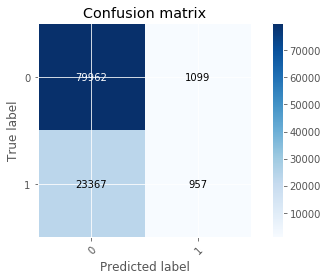

In [220]:
plot_confusion_matrix(y_test, y_pred, [0, 1])

Ввиду разбалансированности классов (нулей больше в 3 раза) неизбежно будет возникать такая ситуация. Выход - балансировка датасета!

# Balancing classes

## Under-sampling

In [224]:
!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

y = initial_df['sold_fast']
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, _ = rus.fit_sample(initial_df.drop(labels=['sold_fast'], axis='columns').values, y.values)

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [230]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                stratify=y_rus, 
                                                test_size=0.3)

In [231]:
model.fit(X_train, y_train, cat_features)

0:	learn: 0.6856215	total: 87.9ms	remaining: 1m 27s
1:	learn: 0.6803103	total: 139ms	remaining: 1m 9s
2:	learn: 0.6771753	total: 193ms	remaining: 1m 3s
3:	learn: 0.6759004	total: 248ms	remaining: 1m 1s
4:	learn: 0.6746615	total: 311ms	remaining: 1m 1s
5:	learn: 0.6736853	total: 378ms	remaining: 1m 2s
6:	learn: 0.6734560	total: 456ms	remaining: 1m 4s
7:	learn: 0.6728320	total: 537ms	remaining: 1m 6s
8:	learn: 0.6726720	total: 589ms	remaining: 1m 4s
9:	learn: 0.6720768	total: 638ms	remaining: 1m 3s
10:	learn: 0.6712161	total: 693ms	remaining: 1m 2s
11:	learn: 0.6707603	total: 756ms	remaining: 1m 2s
12:	learn: 0.6705657	total: 816ms	remaining: 1m 1s
13:	learn: 0.6702217	total: 875ms	remaining: 1m 1s
14:	learn: 0.6698502	total: 939ms	remaining: 1m 1s
15:	learn: 0.6696109	total: 1.01s	remaining: 1m 2s
16:	learn: 0.6689012	total: 1.06s	remaining: 1m 1s
17:	learn: 0.6684316	total: 1.12s	remaining: 1m 1s
18:	learn: 0.6680690	total: 1.18s	remaining: 1m
19:	learn: 0.6678913	total: 1.24s	remainin

163:	learn: 0.6565547	total: 10s	remaining: 51.2s
164:	learn: 0.6564911	total: 10.1s	remaining: 51.2s
165:	learn: 0.6564393	total: 10.2s	remaining: 51.2s
166:	learn: 0.6563667	total: 10.3s	remaining: 51.3s
167:	learn: 0.6563245	total: 10.4s	remaining: 51.3s
168:	learn: 0.6562833	total: 10.4s	remaining: 51.4s
169:	learn: 0.6562097	total: 10.5s	remaining: 51.4s
170:	learn: 0.6561782	total: 10.6s	remaining: 51.4s
171:	learn: 0.6557762	total: 10.7s	remaining: 51.4s
172:	learn: 0.6556913	total: 10.7s	remaining: 51.3s
173:	learn: 0.6556463	total: 10.8s	remaining: 51.3s
174:	learn: 0.6556047	total: 10.9s	remaining: 51.2s
175:	learn: 0.6555205	total: 10.9s	remaining: 51.1s
176:	learn: 0.6554772	total: 11s	remaining: 51.1s
177:	learn: 0.6554269	total: 11s	remaining: 51s
178:	learn: 0.6554034	total: 11.1s	remaining: 50.9s
179:	learn: 0.6553910	total: 11.2s	remaining: 50.8s
180:	learn: 0.6553287	total: 11.2s	remaining: 50.7s
181:	learn: 0.6552498	total: 11.3s	remaining: 50.6s
182:	learn: 0.655215

325:	learn: 0.6489214	total: 20.1s	remaining: 41.6s
326:	learn: 0.6489029	total: 20.2s	remaining: 41.6s
327:	learn: 0.6488637	total: 20.3s	remaining: 41.5s
328:	learn: 0.6488310	total: 20.3s	remaining: 41.4s
329:	learn: 0.6487960	total: 20.4s	remaining: 41.4s
330:	learn: 0.6487428	total: 20.4s	remaining: 41.3s
331:	learn: 0.6486948	total: 20.5s	remaining: 41.2s
332:	learn: 0.6486652	total: 20.5s	remaining: 41.1s
333:	learn: 0.6486222	total: 20.6s	remaining: 41s
334:	learn: 0.6485936	total: 20.6s	remaining: 41s
335:	learn: 0.6485502	total: 20.7s	remaining: 40.9s
336:	learn: 0.6485234	total: 20.8s	remaining: 40.8s
337:	learn: 0.6484778	total: 20.8s	remaining: 40.7s
338:	learn: 0.6484359	total: 20.9s	remaining: 40.7s
339:	learn: 0.6484133	total: 20.9s	remaining: 40.6s
340:	learn: 0.6483831	total: 20.9s	remaining: 40.5s
341:	learn: 0.6483572	total: 21s	remaining: 40.4s
342:	learn: 0.6483167	total: 21s	remaining: 40.3s
343:	learn: 0.6482672	total: 21.1s	remaining: 40.2s
344:	learn: 0.648254

486:	learn: 0.6433246	total: 29.7s	remaining: 31.3s
487:	learn: 0.6432523	total: 29.8s	remaining: 31.3s
488:	learn: 0.6432341	total: 29.8s	remaining: 31.2s
489:	learn: 0.6432286	total: 29.9s	remaining: 31.1s
490:	learn: 0.6431788	total: 29.9s	remaining: 31s
491:	learn: 0.6431685	total: 30s	remaining: 31s
492:	learn: 0.6431521	total: 30s	remaining: 30.9s
493:	learn: 0.6431360	total: 30.1s	remaining: 30.8s
494:	learn: 0.6430971	total: 30.1s	remaining: 30.7s
495:	learn: 0.6430809	total: 30.2s	remaining: 30.7s
496:	learn: 0.6428751	total: 30.2s	remaining: 30.6s
497:	learn: 0.6428676	total: 30.3s	remaining: 30.5s
498:	learn: 0.6428529	total: 30.3s	remaining: 30.5s
499:	learn: 0.6427897	total: 30.4s	remaining: 30.4s
500:	learn: 0.6427875	total: 30.4s	remaining: 30.3s
501:	learn: 0.6427342	total: 30.5s	remaining: 30.3s
502:	learn: 0.6427286	total: 30.6s	remaining: 30.3s
503:	learn: 0.6426942	total: 30.7s	remaining: 30.2s
504:	learn: 0.6426464	total: 30.7s	remaining: 30.1s
505:	learn: 0.642617

646:	learn: 0.6388032	total: 39.8s	remaining: 21.7s
647:	learn: 0.6387653	total: 39.8s	remaining: 21.6s
648:	learn: 0.6387011	total: 39.9s	remaining: 21.6s
649:	learn: 0.6386965	total: 40s	remaining: 21.5s
650:	learn: 0.6386491	total: 40s	remaining: 21.4s
651:	learn: 0.6386155	total: 40.1s	remaining: 21.4s
652:	learn: 0.6386080	total: 40.1s	remaining: 21.3s
653:	learn: 0.6385988	total: 40.2s	remaining: 21.2s
654:	learn: 0.6385857	total: 40.2s	remaining: 21.2s
655:	learn: 0.6385670	total: 40.3s	remaining: 21.1s
656:	learn: 0.6385558	total: 40.4s	remaining: 21.1s
657:	learn: 0.6385375	total: 40.5s	remaining: 21s
658:	learn: 0.6385146	total: 40.6s	remaining: 21s
659:	learn: 0.6385091	total: 40.7s	remaining: 20.9s
660:	learn: 0.6384839	total: 40.7s	remaining: 20.9s
661:	learn: 0.6384279	total: 40.8s	remaining: 20.8s
662:	learn: 0.6384033	total: 40.9s	remaining: 20.8s
663:	learn: 0.6383983	total: 40.9s	remaining: 20.7s
664:	learn: 0.6383545	total: 41s	remaining: 20.7s
665:	learn: 0.6383380	

808:	learn: 0.6346483	total: 49.4s	remaining: 11.7s
809:	learn: 0.6346021	total: 49.4s	remaining: 11.6s
810:	learn: 0.6345693	total: 49.5s	remaining: 11.5s
811:	learn: 0.6345533	total: 49.5s	remaining: 11.5s
812:	learn: 0.6345059	total: 49.6s	remaining: 11.4s
813:	learn: 0.6344852	total: 49.6s	remaining: 11.3s
814:	learn: 0.6344746	total: 49.7s	remaining: 11.3s
815:	learn: 0.6344453	total: 49.7s	remaining: 11.2s
816:	learn: 0.6343954	total: 49.8s	remaining: 11.1s
817:	learn: 0.6343728	total: 49.8s	remaining: 11.1s
818:	learn: 0.6343566	total: 49.9s	remaining: 11s
819:	learn: 0.6343449	total: 49.9s	remaining: 11s
820:	learn: 0.6343357	total: 50s	remaining: 10.9s
821:	learn: 0.6343295	total: 50s	remaining: 10.8s
822:	learn: 0.6343143	total: 50.1s	remaining: 10.8s
823:	learn: 0.6342980	total: 50.1s	remaining: 10.7s
824:	learn: 0.6342905	total: 50.1s	remaining: 10.6s
825:	learn: 0.6342544	total: 50.2s	remaining: 10.6s
826:	learn: 0.6341899	total: 50.2s	remaining: 10.5s
827:	learn: 0.634182

971:	learn: 0.6304754	total: 57.4s	remaining: 1.65s
972:	learn: 0.6304687	total: 57.5s	remaining: 1.59s
973:	learn: 0.6304423	total: 57.5s	remaining: 1.53s
974:	learn: 0.6304290	total: 57.6s	remaining: 1.48s
975:	learn: 0.6304163	total: 57.6s	remaining: 1.42s
976:	learn: 0.6303571	total: 57.7s	remaining: 1.36s
977:	learn: 0.6303170	total: 57.7s	remaining: 1.3s
978:	learn: 0.6303005	total: 57.8s	remaining: 1.24s
979:	learn: 0.6302929	total: 57.8s	remaining: 1.18s
980:	learn: 0.6302611	total: 57.9s	remaining: 1.12s
981:	learn: 0.6302421	total: 57.9s	remaining: 1.06s
982:	learn: 0.6302378	total: 58s	remaining: 1s
983:	learn: 0.6302100	total: 58s	remaining: 943ms
984:	learn: 0.6301615	total: 58.1s	remaining: 884ms
985:	learn: 0.6301218	total: 58.1s	remaining: 825ms
986:	learn: 0.6300661	total: 58.2s	remaining: 766ms
987:	learn: 0.6300277	total: 58.2s	remaining: 707ms
988:	learn: 0.6300124	total: 58.3s	remaining: 648ms
989:	learn: 0.6299428	total: 58.3s	remaining: 589ms
990:	learn: 0.629922

In [232]:
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, roc_auc_score
print('accuracy_score: ', accuracy_score(y_test, y_pred))

y_proba = model.predict_proba(X_test)
print('roc_auc_score: ', roc_auc_score(y_test, y_proba[:, 1]))

accuracy_score:  0.5813188620292715
roc_auc_score:  0.613375518621452


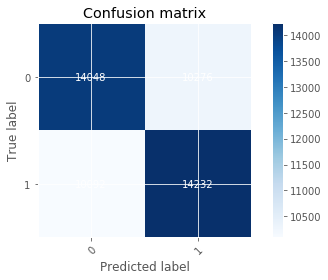

In [233]:
plot_confusion_matrix(y_test, y_pred, [0, 1])

Такого рода балансировка только сократила датасет, мы убрали крен в сторону большего класса, но качество не сильно улучшилось - теперь модель имеет примерно равные FPR, FNR.

Тем не менее, такая модель дала нам лучший результат.